<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_08_Training%2C_Evaluating_and_Tuning_Models_(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: Hospital Length-of-Stay Prediction

---

# 1. Objectives

This notebook serves as an example to demonstrate the codes for training machine learning models for a **regression problem** instead of a classification problem. In actuality, using the following list of input features is most likely flawed as hospital stay-normalized variables such as `LAB_COUNT_DAY` is inherently calculated from LOS. Any applications built on this model would likely be problematic.

---

# 2. Setting up

**Packages for data handling and visualization**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

**Packages for data analysis and modelling**

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

**Import the intermediate dataset and Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in the previous tutorial, you can grant Colab access to your Google Drive and import the intermediate dataset to the current notebook.

Alternatively, when you are working on your own analysis, you may also put everything (e.g. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case, you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True) # you would need to authenicate yourself here

gdrive_rootpath = '/content/gdrive/MyDrive/'
# if you saved the file inside a folder in your Google Drive (instead of the base path),
# you would need to append the folder name to the above

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [6]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaN,STAB WOUND,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaN,PENILE LACERATION-CELLULITIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaN,STATUS EPILEPTICUS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,0,0,1,0
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaN,SUBDURAL HEMATOMA,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaN,CORONARY ARTERY DISEASE,UNKNOWN (DEFAULT),Private,ENGL,...,1,0,1,0,0,0,0,0,1,0


---

# 2. Training, Evaluating and Tuning Models

## 2.1. Train-test Split

We will split the dataset into a training set and a test set with the same codes included in the previous tutorial.

`LOS` would be our prediction target. Here, let's define a list of *36* column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`). (Recall that in our mortality prediction example, we used 38 features instead. The only features excluded here are `LOS` and `LOS_ICU`)

In [7]:
# the only features excluded from the mortality prediction example are 'LOS' and 'LOS_ICU'
features_list = ['GENDER_F', 'AGE',
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY',
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT',
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS',
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

36

 Then, create a DataFrame containing input features only as well as a Series containing our prediction target.

In [8]:
X = df[features_list]
y = df['LOS'] # new prediction target

Finally, use `train_test_split()` from the package [Scikit-learn](https://scikit-learn.org/stable/) to perform a train-test split.

Note that the function outputs four things: the input and output datasets for training and testing respectively.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1) # make sure the split is the same across different devices for illustrative purposes
# note that we do NOT stratify the train and test sets by category as the values of y are NOT categorical

In [10]:
X_train.shape

(47180, 36)

In [11]:
X_test.shape

(11796, 36)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively.

---

## 2.2. Training a Random Forest Model

To train a RF regression model instead of a classification model, we use `RandomForestRegressor()` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) instead of `RandomForestClassifier()`. Model training once again follows the same 3-step process:

1. Specify a model to be trained
2. Train the model with `.fit()`
3. Make predictions with `.predict()`

Define the configuration/hyperparameters of a random forest model. Here we specify that the model contains 200 decision trees and each tree can be split 10 times.

In [12]:
# 1. Specify a model to be trained
# Also define the configuration/hyperparameters of a random forest model.
# Here we specify that the model contains 200 decision trees.
model_rf1 = RandomForestRegressor(n_estimators = 200,
                                  max_depth = 10,
                                  random_state = 1,
                                  n_jobs = -1)

In [13]:
# 2. Train the model
model_rf1.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=1)

In [14]:
# 3. Make predictions
y_pred_rf1 = model_rf1.predict(X_test)
y_pred_rf1

array([ 6.58486597,  4.14400934,  5.57190507, ..., 14.45017201,
        6.69111624,  3.47133074])

In [15]:
err_rf1 = y_pred_rf1 - y_test # compute the residuals (error in prediction)

---

### Evaluation

Mean-squared-error (MSE), Root Mean Squared Error (RMSE) and R<sup>2</sup> are common metrics to report. A full list of available metrics could be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [23]:
# to calculate RMSE:
root_mean_squared_error(y_test, y_pred_rf1)

5.36776865528503

In [24]:
# to calculate R-squared:
r2_score(y_test, y_pred_rf1)

0.808624277676985

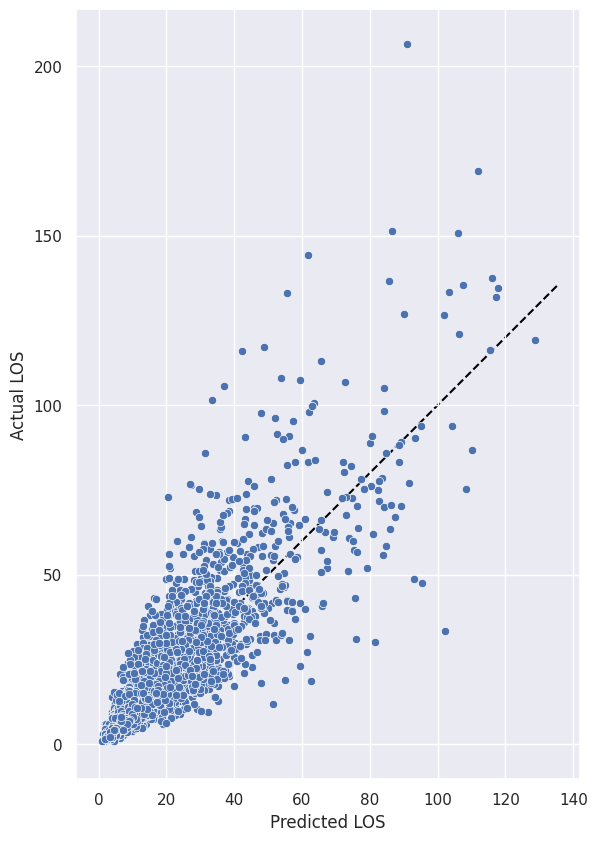

In [25]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf1, y = y_test)
g.set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS', aspect=1) # customise x and y axis titles

# add a predicted=actual line for clarity. Ideally predictions should be close to this line.
diag_line_coor = (0, min(g.get_xlim()[1], g.get_ylim()[1]))
plt.plot(diag_line_coor, diag_line_coor, color="black", ls="--", zorder=0)

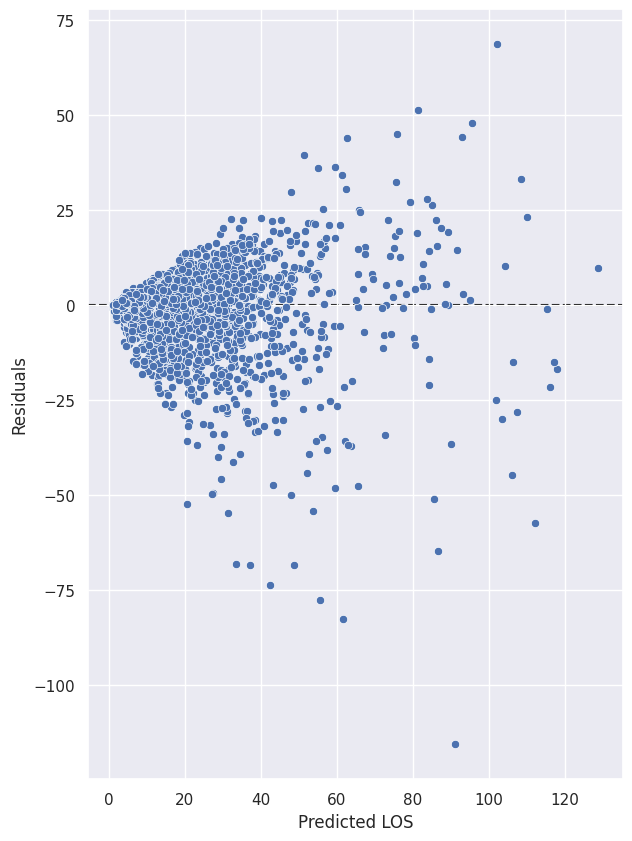

In [26]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf1, y = err_rf1)
g.set(xlabel = 'Predicted LOS', ylabel = 'Residuals', aspect=1) # customise x and y axis titles

# add a horizontal line. Ideally predictions should be close to this line.
plt.axhline(y=0, color="black", ls="--", zorder=0)

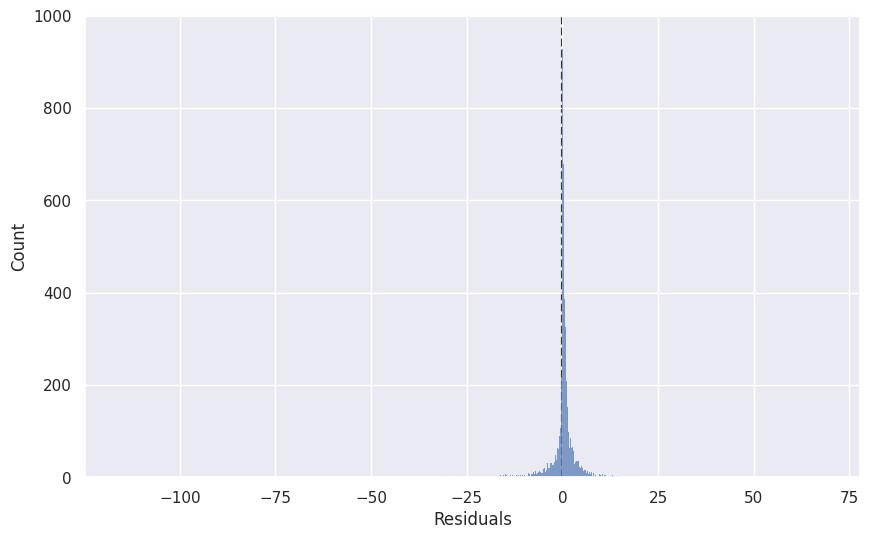

In [27]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf1)
g.set(xlabel = 'Residuals')

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

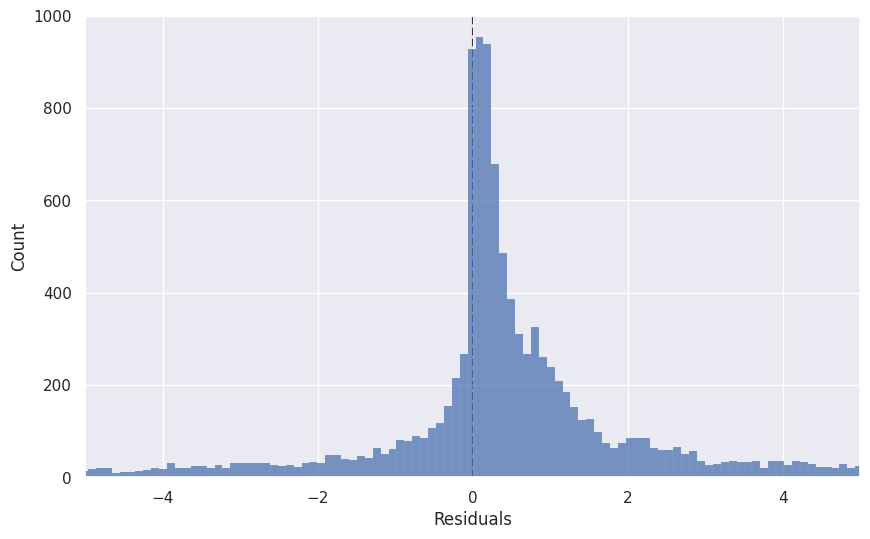

In [28]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf1)
g.set(xlabel = 'Residuals', xlim = (-5, 5)) # specify boundaries for x axis to "zoom in" the plot

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

[Text(0.5, 0, 'Absolute Residuals'),
 Text(0, 0.5, 'Cumulative Percentage'),
 (0.0, 15.0)]

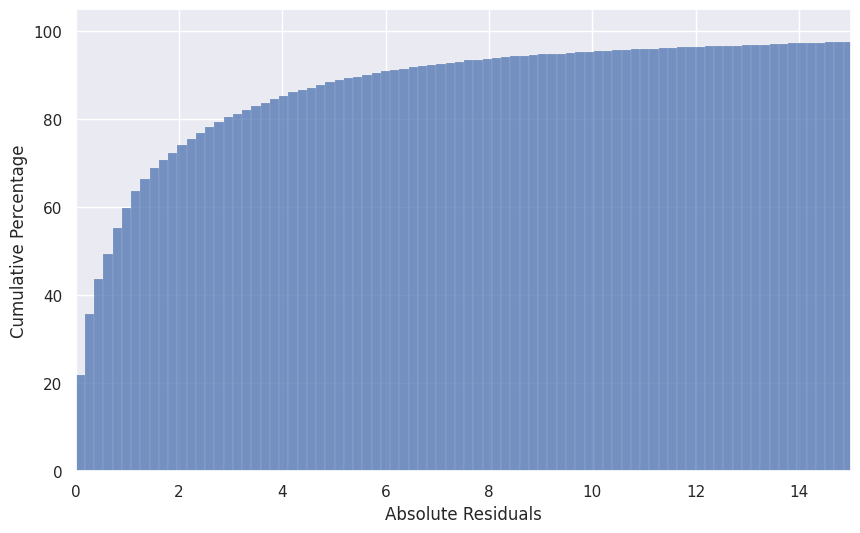

In [29]:
plt.figure(figsize = (10, 6))
g = sns.histplot(abs(err_rf1), cumulative = True, stat = 'percent')
g.set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))

In [30]:
(abs(err_rf1) <= 1).value_counts(normalize=True)

,proportion
LOS,
True,0.579858
False,0.420142


In [31]:
(abs(err_rf1) <= 3).value_counts(normalize=True)

,proportion
LOS,
True,0.80273
False,0.19727


**Some Observations**

* From the residuals against predicted LOS plot, the model is mostly able (58.0%) to predict those with LOS within 1 day.

* The model is able to predict LOS within a 3-day difference 80% of the time.

---

## 2.4. Tuning a Random Forest Model

Hyperparameters are a pre-defined set of configurations of a machine learning model. Examples of that include the number of decision trees as well as the depth of each tree in a random forest model. Although Scikit-learn provides a good set of default values for you to start with, these hyperparameters often need to be tuned for further optimise the model's performance.

Now, we try to **tune the hyperparameters** of the random forest model above based on **cross-validation** and **grid search**. We apply the `GridSearchCV()` function and specify a list of hyperparameters and their respective values to be tested. Models are **trained for each combination of potential values and fold**. The **best performing** set of hyperparameters across all folds would then be reported and used.

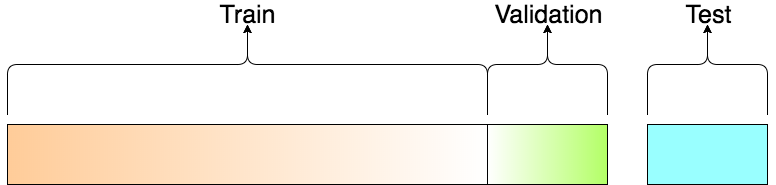

([Source](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7))

![train-validation-test split](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

([Source](https://scikit-learn.org/stable/))

Performing this step requires at least a basic understanding on the meaning and effect of each hyperparameter. You should always refer to the docs of the model you are using in this step ([RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) in this case). An explanation of Random Forest hyperparameters can also be found [here](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/). You may also go back to the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) model we used in the previous tutorial and tune it with very similar code.

In [ ]:
# a set of hyperparameters and their respective values to be tested

param_grid = {
    'n_estimators': [30, 100, 300],    # number of decision trees in the forest
    'max_depth': [2, 10, None],        # how many times can each tree be split. 'None' means no specific limit.
    'min_samples_leaf': [1, 3, 10]     # minimum number of samples required to be at a leaf node.
}

In [ ]:
grid_search_rf = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 1, n_jobs = -1),  # define type of model to be tuned
    param_grid = param_grid,                                           # hyperparameters to be tested
    cv = 5,                                                            # 5-fold cross-validation
    scoring = 'neg_root_mean_squared_error',                           # metric to be optimized. You may use 'f1' for classification problems.
    verbose = 2
    )

In [ ]:
%%time

grid_search_rf.fit(X_train, y_train)

# WARNING: this would take **50 minutes** to run
# this could be shorter or take even longer depending on the number of hyperparameters to be tested, number of folds and the size of the dataset

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   2.3s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.3s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.9s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   2.2s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.4s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   4.1s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   4.1s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   5.6s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   4.4s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   6.6s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=300; total time=  14.9s
[CV] END ..max_depth=2, min_samples_leaf=1, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             param_grid={'max_depth': [2, 10, None],
                         'min_samples_leaf': [1, 3, 10],
                         'n_estimators': [30, 100, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

### Tuning Results

Retrieve the best performing set of hyperparams using `.best_params_`

In [ ]:
grid_search_rf.best_params_

{'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 300}

Retrieve the best performing model from `.best_estimator_` and save it as a seperate variable.

In [ ]:
model_rf2 = grid_search_rf.best_estimator_

Use `.cv_results_` in case you want to look into the details of each set of hyperparams. This could help you determine the apprioriate range of each hyperparameter, and thus setting up better `param_grid`'s in any subsequent tuning using more refined ranges. In the example below, we can deduce that having a `max_depth` of 2 is insufficient.

In [ ]:
rf_cv_results = pd.DataFrame(grid_search_rf.cv_results_)
rf_cv_results = rf_cv_results.fillna('None')
rf_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.808116,0.415585,0.013721,0.001534,2,1,30,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",-7.583093,-7.655564,-7.515730,-7.080157,-7.164779,-7.399865,0.232318,25
1,4.936568,0.966330,0.045812,0.020872,2,1,100,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",-7.538487,-7.652547,-7.514104,-7.059364,-7.145736,-7.382048,0.234542,22
2,14.359697,1.062550,0.079637,0.002869,2,1,300,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",-7.522216,-7.644925,-7.505955,-7.059552,-7.156063,-7.377742,0.227633,19
3,1.589169,0.375197,0.013393,0.000942,2,3,30,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",-7.583093,-7.655564,-7.515730,-7.080157,-7.164779,-7.399865,0.232318,25
4,4.362240,0.634477,0.028625,0.001241,2,3,100,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",-7.538487,-7.652547,-7.514104,-7.059364,-7.145736,-7.382048,0.234542,22
5,14.057519,1.179985,0.086275,0.013796,2,3,300,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",-7.522216,-7.644925,-7.505955,-7.059552,-7.156063,-7.377742,0.227633,19
6,1.315265,0.019173,0.013195,0.000686,2,10,30,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_es...",-7.583093,-7.655564,-7.515730,-7.080157,-7.164779,-7.399865,0.232318,25
7,4.658770,0.739102,0.028593,0.001346,2,10,100,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_es...",-7.538487,-7.652547,-7.514104,-7.059364,-7.145736,-7.382048,0.234542,22
8,14.018502,1.142422,0.088176,0.018198,2,10,300,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_es...",-7.522216,-7.644925,-7.505955,-7.059552,-7.156063,-7.377742,0.227633,19
9,6.900572,0.834483,0.039167,0.017322,10,1,30,"{'max_depth': 10, 'min_samples_leaf': 1, 'n_es...",-5.449060,-5.689661,-5.545040,-5.363480,-5.168147,-5.443078,0.175019,18


<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

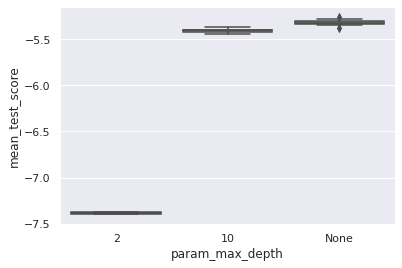

In [ ]:
sns.boxplot(x = 'param_max_depth', y = 'mean_test_score', data = rf_cv_results)
# it is very apparent that a param_max_depth of 2 leads to the worst results

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

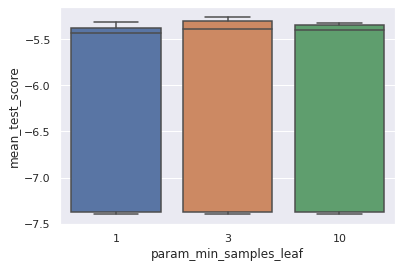

In [ ]:
sns.boxplot(x = 'param_min_samples_leaf', y = 'mean_test_score', data = rf_cv_results)
# cannot see too much difference because the outliers (the ones with max_depth 2)

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

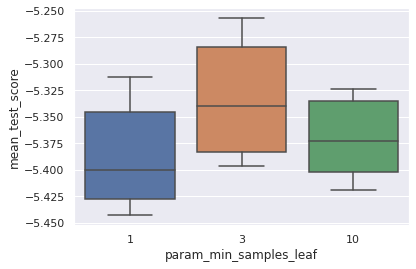

In [ ]:
sns.boxplot(x = 'param_min_samples_leaf', y = 'mean_test_score', data = rf_cv_results[rf_cv_results['param_max_depth'] != 2])
# removing outliers (the ones with max_depth 2) for better clarity
# setting min_samples_leaf to be 3 seems marginally better

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

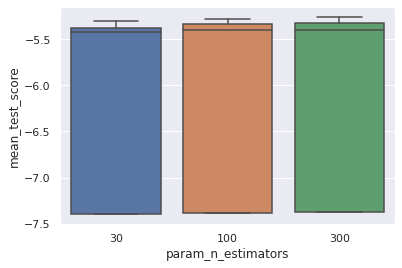

In [ ]:
sns.boxplot(x = 'param_n_estimators', y = 'mean_test_score', data = rf_cv_results)
# cannot see too much difference because the outliers (the ones with max_depth 2)

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

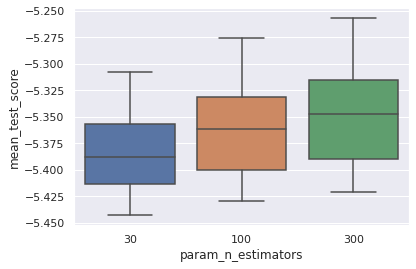

In [ ]:
sns.boxplot(x = 'param_n_estimators', y = 'mean_test_score', data = rf_cv_results[rf_cv_results['param_max_depth'] != 2])
# removing outliers (the ones with max_depth 2) for better clarity
# setting n_estimators to be 300 seems marginally better

### Evaluation

In [37]:
y_pred_rf2 = model_rf2.predict(X_test)
err_rf2 = y_pred_rf2 - y_test

In [40]:
# to calculate RMSE:
root_mean_squared_error(y_test, y_pred_rf2)

5.228822153839208

In [41]:
# to calculate R-squared:
r2_score(y_test, y_pred_rf2)

0.8184036964377467

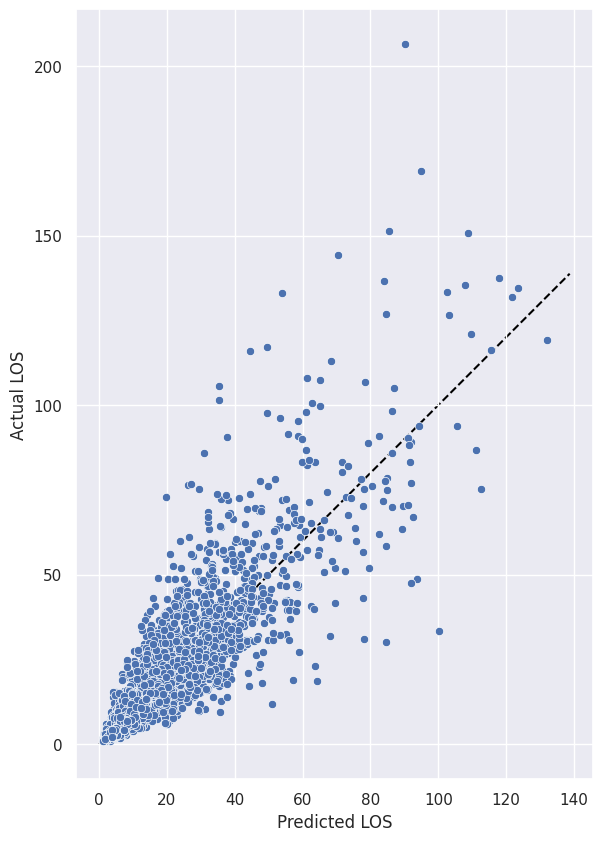

In [42]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf2, y = y_test)
g.set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS', aspect=1)

# add a predicted=actual line for clarity. Ideally predictions should be close to this line.
diag_line_coor = (0, min(g.get_xlim()[1], g.get_ylim()[1]))
plt.plot(diag_line_coor, diag_line_coor, color="black", ls="--", zorder=0)

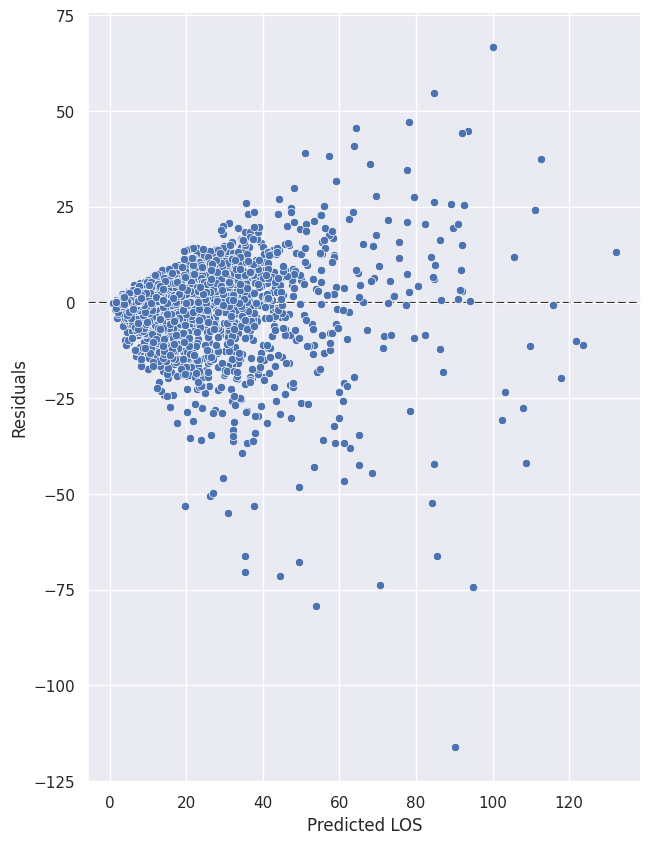

In [43]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf2, y = err_rf2)
g.set(xlabel = 'Predicted LOS', ylabel = 'Residuals', aspect=1)

# add a horizontal line. Ideally predictions should be close to this line.
plt.axhline(y=0, color="black", ls="--", zorder=0)

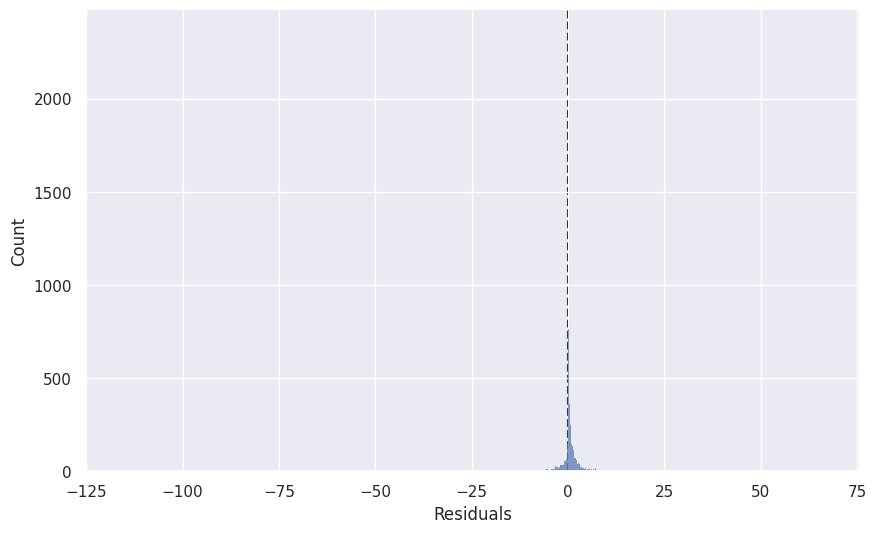

In [44]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf2)
g.set(xlabel = 'Residuals')

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

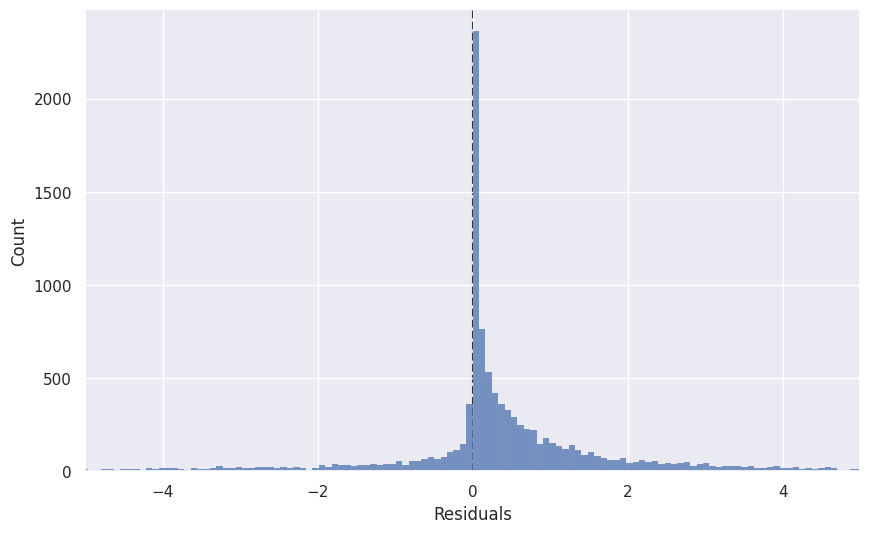

In [45]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf2)
g.set(xlabel = 'Residuals', xlim = (-5, 5)) # specify boundaries for x axis to zoom in

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

[Text(0.5, 0, 'Absolute Residuals'),
 Text(0, 0.5, 'Cumulative Percentage'),
 (0.0, 15.0)]

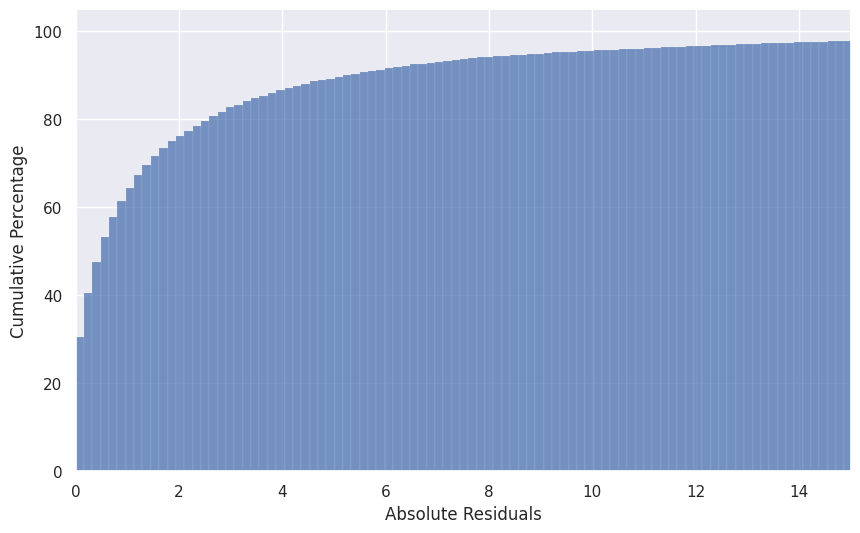

In [46]:
plt.figure(figsize = (10, 6))
g = sns.histplot(abs(err_rf2), cumulative = True, stat = 'percent')
g.set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))

In [47]:
(abs(err_rf2) <= 1).value_counts(normalize=True)

,proportion
LOS,
True,0.62021
False,0.37979


In [48]:
(abs(err_rf2) <= 3).value_counts(normalize=True)

,proportion
LOS,
True,0.82155
False,0.17845


**Some Observations**

* Model performance improved across all metrics. The model is able to predict LOS within a 1-day difference 62% of the time (up from 58%).

---

## 2.5. Understanding a Random Forest Model

Similar to RF models for classification, **feature importance** can be a powerful tool to help you find insights in the model.

In [49]:
model_rf2_importance = pd.Series(model_rf2.feature_importances_, index = features_list).sort_values(ascending=False)
model_rf2_importance

,0
TRANSFER_COUNT_DAY,0.752188
PROC_COUNT_DAY,0.084105
CALLOUT_COUNT_DAY,0.042411
LAB_COUNT_DAY,0.019263
MICRO_COUNT_DAY,0.017183
OUTPUT_COUNT_DAY,0.015846
PRES_COUNT_DAY,0.014205
INPUTS_CV_COUNT_DAY,0.011252
CPT_COUNT_DAY,0.011013
AGE,0.008357


<Axes: xlabel='None', ylabel='None'>

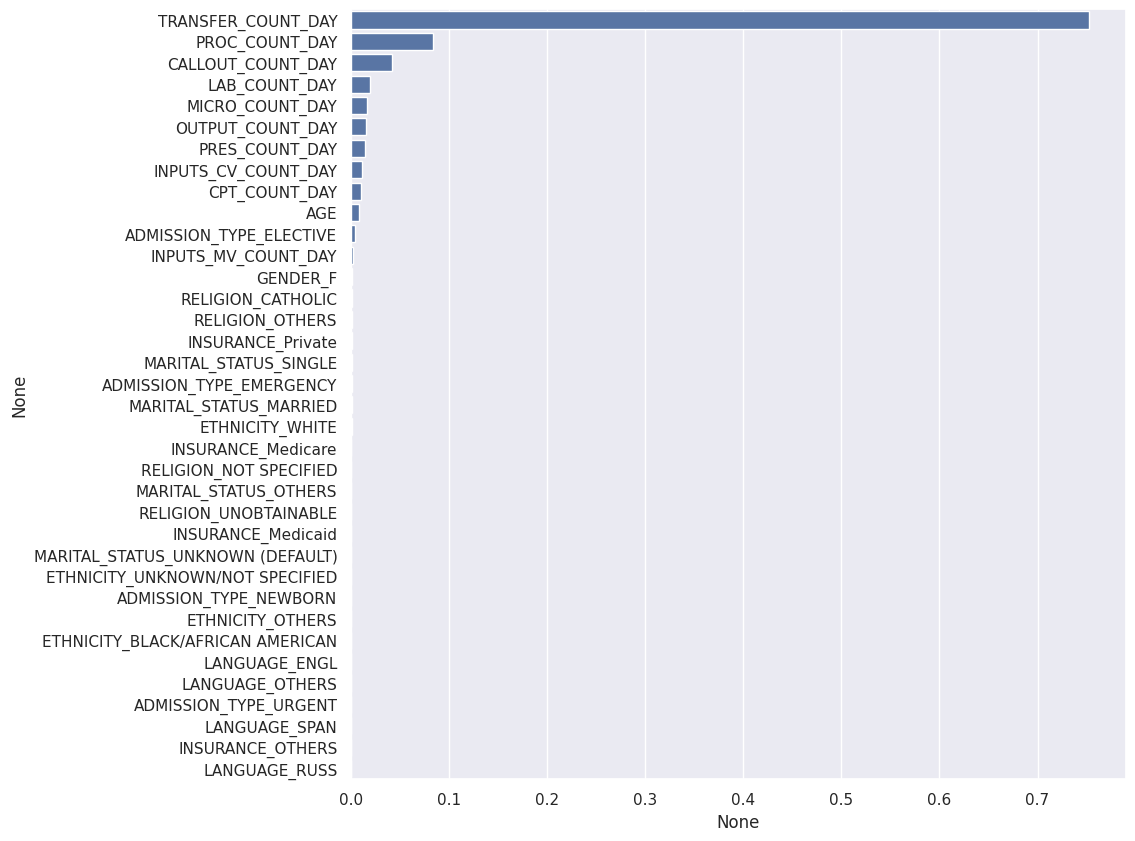

In [50]:
plt.figure(figsize = (10, 10))
sns.barplot(x = model_rf2_importance, y = model_rf2_importance.index)

**Some Observations**

* This variable importance plot could be an evidence of the variable `TRANSFER_COUNT_DAY` being systematically tied to LOS due to their uniquely strong association. Note that `TRANSFER_COUNT` stands for the total number of change in physical locations for patients throughout their hospital stay ([documentation](https://mimic.mit.edu/docs/iii/tables/transfers/)), and `TRANSFER_COUNT_DAY` is the daily average version of it.

<Axes: xlabel='TRANSFER_COUNT_DAY', ylabel='LOS'>

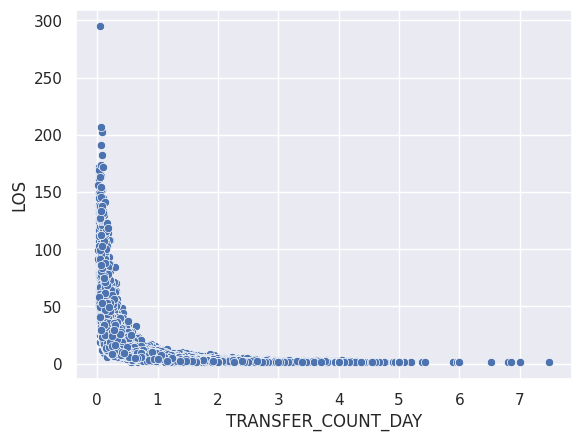

In [51]:
sns.scatterplot(x = 'TRANSFER_COUNT_DAY', y = 'LOS', data = df)

* The model likely learnt that any patients with `TRANSFER_COUNT_DAY` > 1 tends to have a short LOS.

<Axes: xlabel='TRANSFER_COUNT', ylabel='LOS'>

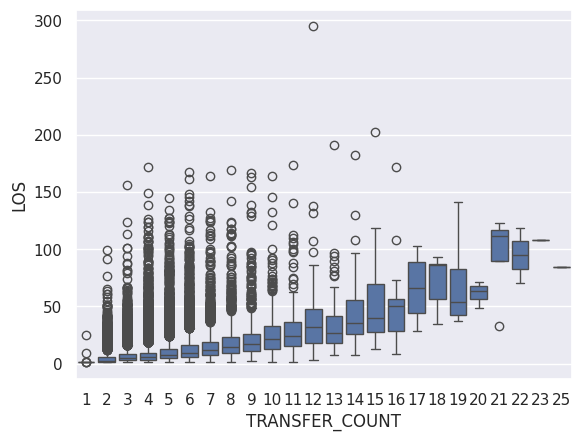

In [52]:
sns.boxplot(x = 'TRANSFER_COUNT', y = y_train, data = df)

---

## 2.6. Training a Neural Network

Neural network has been a backbone of many modern AI algorithms and has a wide spread of applications such as image recognition and natural language processing.

In fact, neural networks for supervised learning, in their simpliest form, are highly similar to linear or logistic regression models. Linear or logistic regression models can be thought of as a one-layer neural network; and neural networks can be thought of as multiple linear or logistic models being stacked and trained together. Of course, there are a lot of nuances when it comes to setting up and training a working neural network but that would be beyond the scope of this tutorial here.



<img src='https://cdnsciencepub.com/cms/10.1139/er-2020-0019/asset/images/large/er-2020-0019f2.jpeg' width='70%'>

(Jain, 2020)


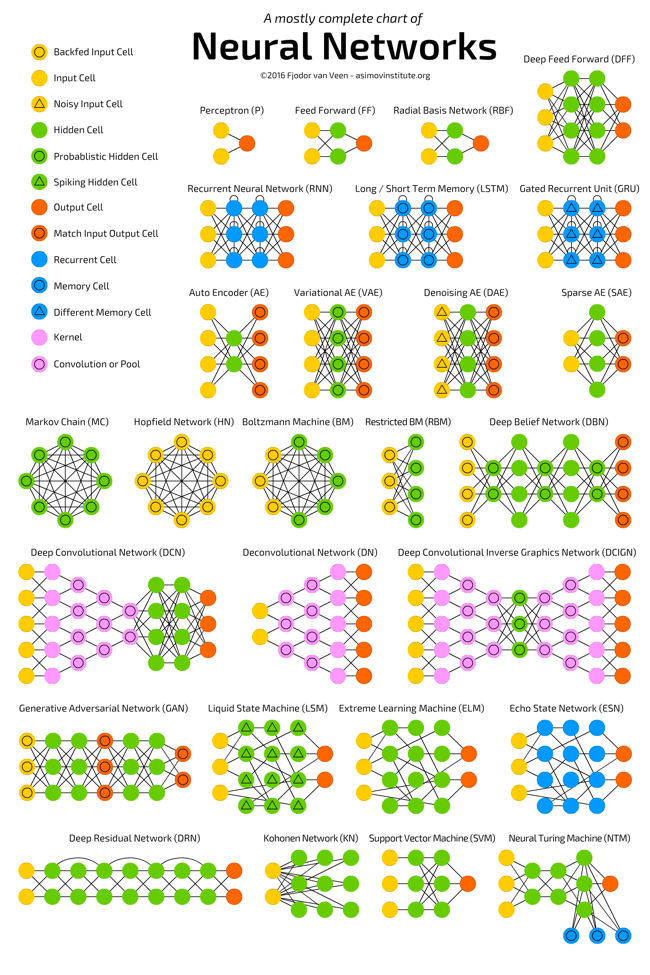

(Fjodor van Veen, 2016)

In [54]:
# 1. Specify a model to be trained
# Also define the configuration/hyperparameters of a random forest model.
# Here we specify that the NN model contains 2 hidden layers with 20 and 5 nodes respectively.
# All other parameters are set to default.
model_nn = MLPRegressor(hidden_layer_sizes=(20, 5),
                        random_state = 1)

In [55]:
# 2. Train the model
%%time
model_nn.fit(X_train, y_train)

CPU times: user 28.6 s, sys: 76.2 ms, total: 28.6 s
Wall time: 29.4 s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(20, 5), random_state=1)

In [56]:
# 3. Make predictions
y_pred_nn = model_nn.predict(X_test)
y_pred_nn

array([ 6.53675642,  4.95140921,  7.54236782, ..., 10.84502272,
        6.95586668,  4.44883269])

In [57]:
err_nn = y_pred_nn - y_test # compute the residuals (error in prediction)

---

### Evaluation

In [58]:
# to calculate RMSE:
root_mean_squared_error(y_test, y_pred_nn)

5.978482527435837

In [59]:
# to calculate R-squared:
r2_score(y_test, y_pred_nn)

0.7625997392587707

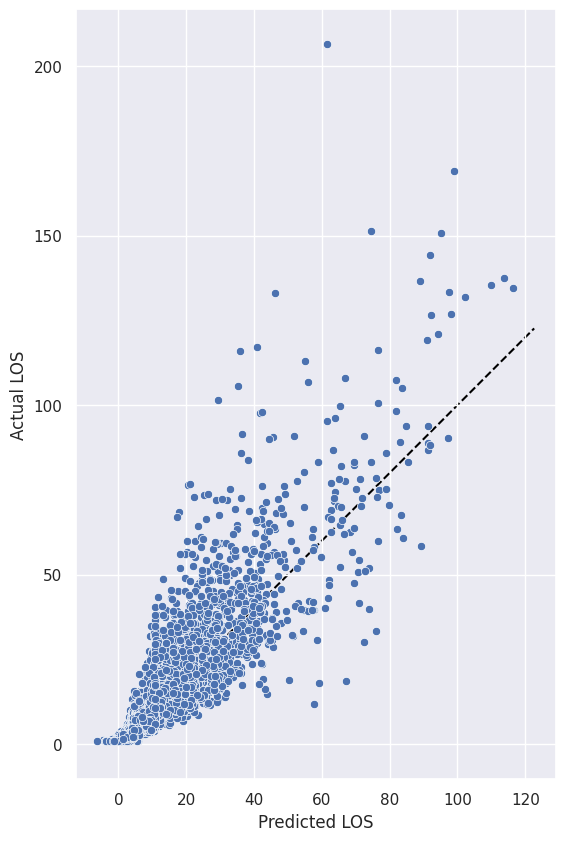

In [60]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_nn, y = y_test)
g.set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS', aspect=1)

# add a predicted=actual line for clarity. Ideally predictions should be close to this line.
diag_line_coor = (0, min(g.get_xlim()[1], g.get_ylim()[1]))
plt.plot(diag_line_coor, diag_line_coor, color="black", ls="--", zorder=0)

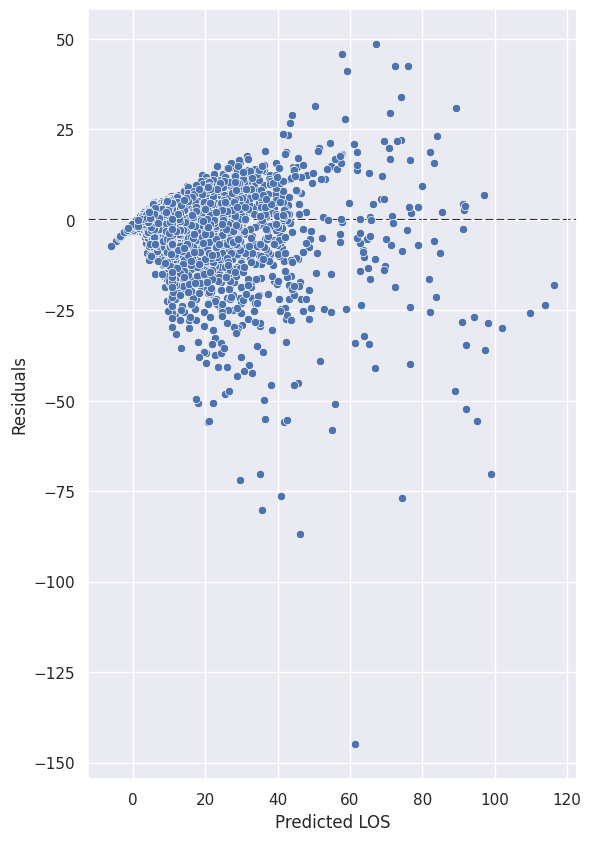

In [61]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_nn, y = err_nn)
g.set(xlabel = 'Predicted LOS', ylabel = 'Residuals', aspect=1)

# add a horizontal line. Ideally predictions should be close to this line.
plt.axhline(y=0, color="black", ls="--", zorder=0)

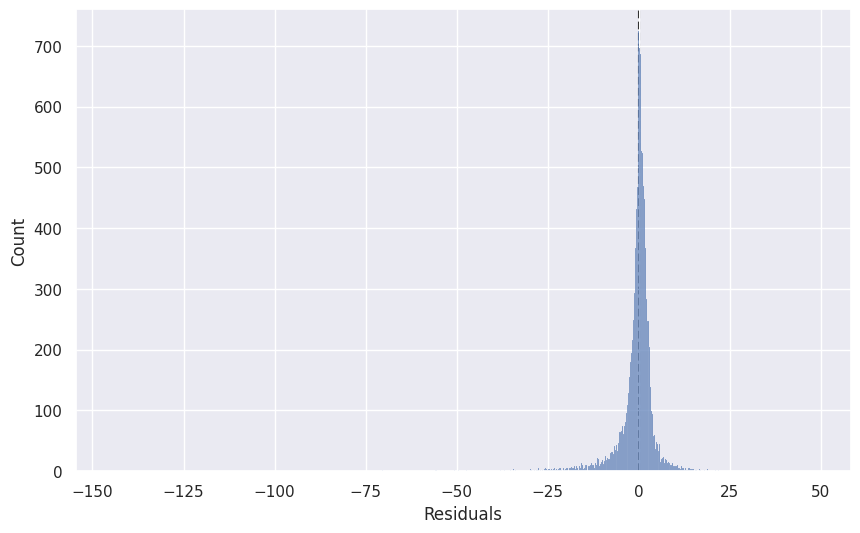

In [62]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_nn)
g.set(xlabel = 'Residuals')

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

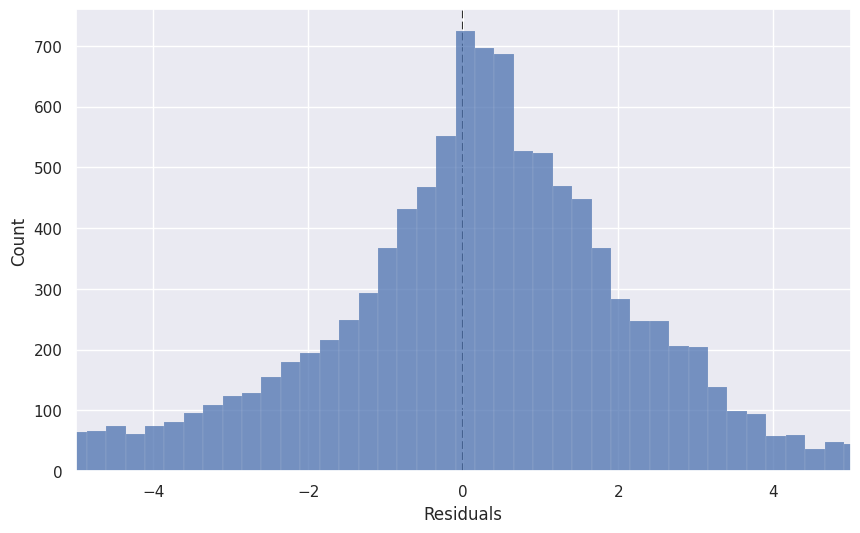

In [63]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_nn)
g.set(xlabel = 'Residuals', xlim = (-5, 5)) # specify boundaries for x axis to zoom in

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

[Text(0.5, 0, 'Absolute Residuals'),
 Text(0, 0.5, 'Cumulative Percentage'),
 (0.0, 15.0)]

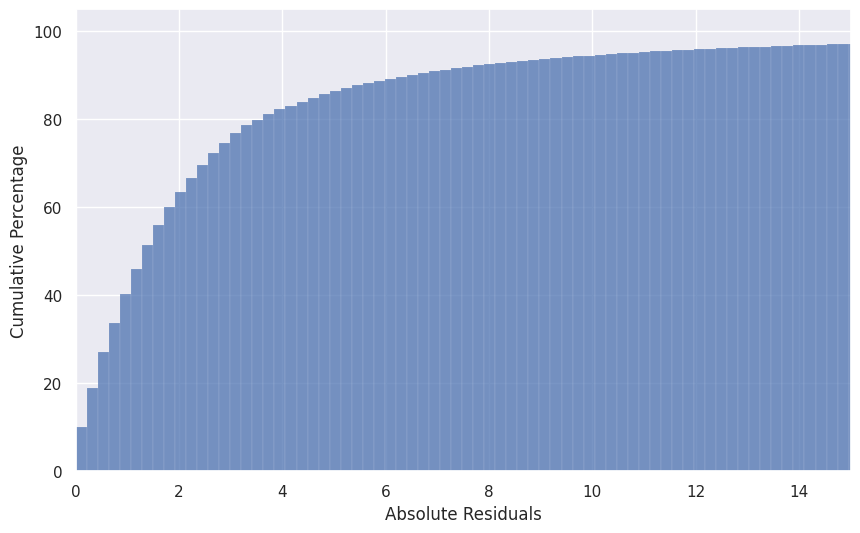

In [64]:
plt.figure(figsize = (10, 6))
g = sns.histplot(abs(err_nn), cumulative = True, stat = 'percent')
g.set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))

**Some Observations**

* The neural network is worse than both the tuned and untuned RF models. Tuning hyperparameters and including NN-specific pre-processing procedures are needed for it to produce good results.

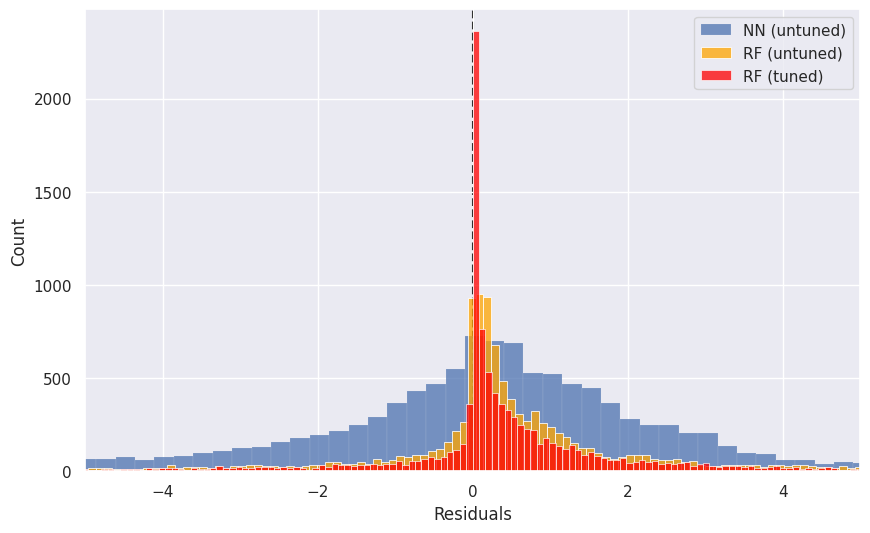

In [75]:
plt.figure(figsize = (10, 6))
sns.histplot(err_nn, label = 'NN (untuned)').set(xlabel = 'Residuals', xlim = (-5, 5)) # specify boundaries for x axis to zoom in
sns.histplot(err_rf1, label = 'RF (untuned)', color = 'orange')
sns.histplot(err_rf2, label = 'RF (tuned)', color = 'red')

plt.legend()

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

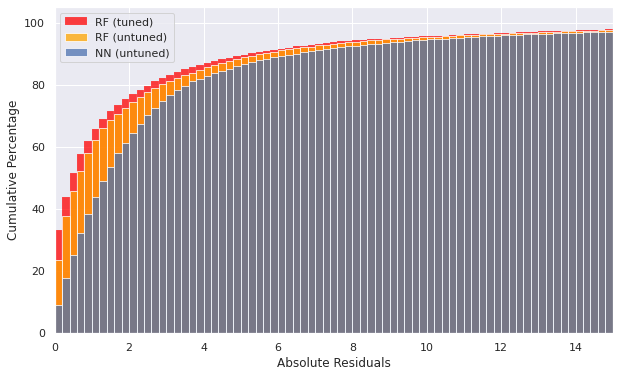

In [ ]:
plt.figure(figsize = (10, 6))
sns.histplot(abs(err_rf2), cumulative = True, binwidth = .2, stat = 'percent', label = 'RF (tuned)',   color = 'red').set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))
sns.histplot(abs(err_rf1), cumulative = True, binwidth = .2, stat = 'percent', label = 'RF (untuned)', color = 'orange')
sns.histplot(abs(err_nn),  cumulative = True, binwidth = .2, stat = 'percent', label = 'NN (untuned)')
plt.legend()

---

# References

* Jain, P., Coogan, S. C., Subramanian, S. G., Crowley, M., Taylor, S., & Flannigan, M. D. (2020). A review of machine learning applications in wildfire science and management. Environmental Reviews, 28(4), 478-505.